In [573]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
from scipy.stats import pearsonr
from adjustText import adjust_text
from statannot import add_stat_annotation
from scipy.stats import ttest_1samp
import matplotlib.lines as mlines
from scipy import stats
from statsmodels.stats.multitest import multipletests
import sys
import os
import glob
import pertpy as pt
sys.path.append(os.path.abspath('../'))
from DE_analysis_utils import get_DE_results_long
import matplotlib as mpl
plt.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'NimbusSanL'

In [2]:
datadir = '../../../../3_expts/processed_data'
de_by_guide = pd.read_csv('./results/DE_by_guide.correlation_results.csv', index_col=0)
donor_robustness_summary = pd.read_csv('./results/DE_donor_robustness_correlation_summary.csv', index_col=0)
de_summary_stats = pd.read_csv(datadir + '/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)

In [3]:
adata_de = ad.read_h5ad(datadir + '/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad', backed=True)
de_donor_robustness = ad.read_h5ad(datadir + '/CD4i_final/CD4i_final.DE_donor_robustness.h5ad', backed=True)

## Plot volcano plot from Perturb-seq

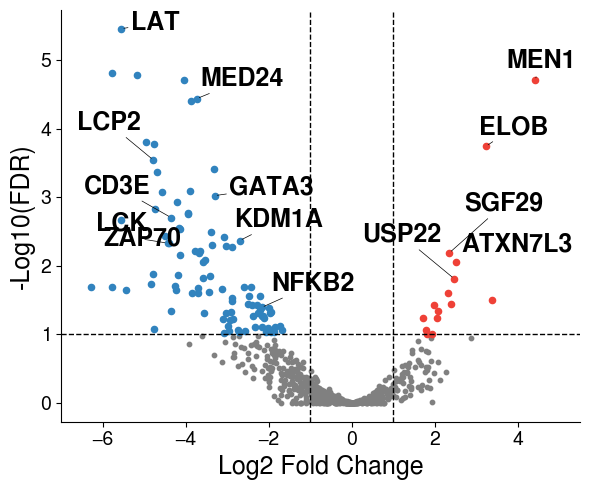

In [317]:
target_gene = 'IL10'
robust_thres = 0.35
adj_p_thres = 0.1
log_fc_thres = 1

obs_mask = (adata_de.obs.target_contrast_gene_name.isin(donor_robustness_summary[(donor_robustness_summary['donor_correlation_min']>robust_thres)&\
    (donor_robustness_summary['condition']=='Stim8hr')]['target_name'].unique()))&(adata_de.obs.culture_condition=='Stim8hr')
var_mask = (adata_de.var.gene_name==target_gene)
log_fc = adata_de[obs_mask, var_mask].layers['log_fc'][:, 0].copy()
adj_pvals = adata_de[obs_mask, var_mask].layers['adj_p_value'][:, 0].copy()
gene_names = adata_de[obs_mask, var_mask].obs['target_contrast_gene_name_corrected'].values
neg_log10_pval = -np.log10(np.clip(adj_pvals, 1e-300, 1))

# Significance mask
is_signif_neg = (adj_pvals < adj_p_thres) & (log_fc > log_fc_thres)
is_signif_pos = (adj_pvals < adj_p_thres) & (log_fc < -log_fc_thres)
sig_log_fc = log_fc[is_signif_neg|is_signif_pos]
sig_pval = adj_pvals[is_signif_neg|is_signif_pos]
sig_names = gene_names[is_signif_neg|is_signif_pos]
sig_neglogp = neg_log10_pval[is_signif_neg|is_signif_pos]

# Get top N significant genes
top_n = 50
left_mask = sig_log_fc < 0
left_idx = np.argsort(-sig_neglogp[left_mask])[:top_n]
left_genes = sig_names[left_mask][left_idx]
right_mask = sig_log_fc > 0
right_idx = np.argsort(-sig_neglogp[right_mask])[:top_n]
right_genes = sig_names[right_mask][right_idx]
#annot_genes = np.array(list(set(left_genes)|set(right_genes)|set(['MEN1', 'ELOB', 'ARRDC4', 'SGF29', 'GATA3', 'MED24', 'KDM1A', 'NFKB2'])))
annot_genes = np.array(list(set(['LAT', 'LCP2', 'CD3E', 'LCK', 'ZAP70', 
                                 'ATXN7L3', 'USP22', 'MEN1', 'ELOB',
                                 'SGF29', 'GATA3', 'MED24', 'KDM1A', 'NFKB2'])))

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(log_fc, neg_log10_pval, c='grey', s=10, label='Not significant')
plt.scatter(log_fc[is_signif_pos], neg_log10_pval[is_signif_pos], c='#3183be', s=20, label=f'adj_p < {adj_p_thres} & |logFC| > {log_fc_thres}')
plt.scatter(log_fc[is_signif_neg], neg_log10_pval[is_signif_neg], c='#ef4137', s=20, label=f'adj_p < {adj_p_thres} & |logFC| > {log_fc_thres}')

# Reference lines
left_vline_object = plt.axvline(-log_fc_thres, color='black', linestyle='--', linewidth=1)
right_vline_object = plt.axvline(log_fc_thres, color='black', linestyle='--', linewidth=1)
hline_object = plt.axhline(-np.log10(adj_p_thres), color='black', linestyle='--', linewidth=1)

lines_to_avoid = [left_vline_object, right_vline_object, hline_object]

plt.xlim([-7,5.5])

# Labels
texts = []
for gene in annot_genes:
    idx = np.where(gene_names == gene)[0][0]
    texts.append(
        plt.text(log_fc[idx], neg_log10_pval[idx], gene,
                 fontsize=18, weight='bold', ha='center', va='bottom')
    )

# Adjust to avoid collisions
adjust_text(texts,
            x=log_fc[is_signif_pos|is_signif_neg],
            y=neg_log10_pval[is_signif_pos|is_signif_neg],
            objects=lines_to_avoid,
            force_static=(5, 10),
            force_text=(0.1, 0.2),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Labels and formatting
plt.xlabel('Log2 Fold Change', fontsize=18)
plt.ylabel('-Log10(FDR)', fontsize=18)
#plt.title(f'Volcano Plot for {target_gene} Perturbation', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12)

sns.despine()
plt.tight_layout()
plt.savefig('./results/IL10_volcano.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

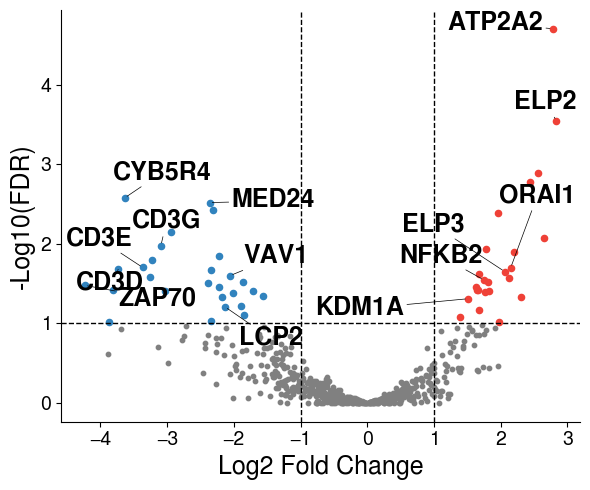

In [316]:
target_gene = 'IL21'
robust_thres = 0.35
adj_p_thres = 0.1
log_fc_thres = 1

obs_mask = (adata_de.obs.target_contrast_gene_name.isin(donor_robustness_summary[(donor_robustness_summary['donor_correlation_min']>robust_thres)&\
    (donor_robustness_summary['condition']=='Stim8hr')]['target_name'].unique()))&(adata_de.obs.culture_condition=='Stim8hr')
var_mask = (adata_de.var.gene_name==target_gene)
log_fc = adata_de[obs_mask, var_mask].layers['log_fc'][:, 0].copy()
adj_pvals = adata_de[obs_mask, var_mask].layers['adj_p_value'][:, 0].copy()
gene_names = adata_de[obs_mask, var_mask].obs['target_contrast_gene_name_corrected'].values
neg_log10_pval = -np.log10(np.clip(adj_pvals, 1e-300, 1))

# Significance mask
is_signif_neg = (adj_pvals < adj_p_thres) & (log_fc > log_fc_thres)
is_signif_pos = (adj_pvals < adj_p_thres) & (log_fc < -log_fc_thres)
sig_log_fc = log_fc[is_signif_neg|is_signif_pos]
sig_pval = adj_pvals[is_signif_neg|is_signif_pos]
sig_names = gene_names[is_signif_neg|is_signif_pos]
sig_neglogp = neg_log10_pval[is_signif_neg|is_signif_pos]

# Get top N significant genes
top_n = 5
left_mask = sig_log_fc < 0
left_idx = np.argsort(-sig_neglogp[left_mask])[:top_n]
left_genes = sig_names[left_mask][left_idx]
right_mask = sig_log_fc > 0
right_idx = np.argsort(-sig_neglogp[right_mask])[:top_n]
right_genes = sig_names[right_mask][right_idx]
#annot_genes = np.array(list(set(left_genes)|set(right_genes)|set(['MEN1', 'CYB5R4', 'MED24', 'KDM1A', 'NFKB2', 'PPCS'])))
annot_genes = np.array(list(set(['CD3G', 'CD3E', 'CD3D', 'VAV1', 'ZAP70', 'LCP2', 
                                 'ELP2', 'ELP3', 'ORAI1', 'ATP2A2', 'CYB5R4', 'MED24', 'KDM1A', 'NFKB2'])))

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(log_fc, neg_log10_pval, c='grey', s=10, label='Not significant')
plt.scatter(log_fc[is_signif_pos], neg_log10_pval[is_signif_pos], c='#3183be', s=20, label=f'adj_p < {adj_p_thres} & |logFC| > {log_fc_thres}')
plt.scatter(log_fc[is_signif_neg], neg_log10_pval[is_signif_neg], c='#ef4137', s=20, label=f'adj_p < {adj_p_thres} & |logFC| > {log_fc_thres}')

# Reference lines
left_vline_object = plt.axvline(-log_fc_thres, color='black', linestyle='--', linewidth=1)
right_vline_object = plt.axvline(log_fc_thres, color='black', linestyle='--', linewidth=1)
hline_object = plt.axhline(-np.log10(adj_p_thres), color='black', linestyle='--', linewidth=1)

lines_to_avoid = [left_vline_object, right_vline_object, hline_object]

# Labels
texts = []
for gene in annot_genes:
    idx = np.where(gene_names == gene)[0][0]
    texts.append(
        plt.text(log_fc[idx], neg_log10_pval[idx], gene,
                 fontsize=18, weight='bold', ha='center', va='bottom')
    )

# Adjust to avoid collisions
adjust_text(texts,
            x=log_fc[is_signif_pos|is_signif_neg],
            y=neg_log10_pval[is_signif_pos|is_signif_neg],
            objects=lines_to_avoid,
            force_static=(5, 10),
            force_text=(5, 10),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Labels and formatting
plt.xlabel('Log2 Fold Change', fontsize=18)
plt.ylabel('-Log10(FDR)', fontsize=18)
#plt.title(f'Volcano Plot for {target_gene} Perturbation', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12)
sns.despine()
plt.tight_layout()
plt.savefig('./results/IL21_volcano.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

## Make Perturb-seq heatmap

In [466]:
colormap_thres = 3

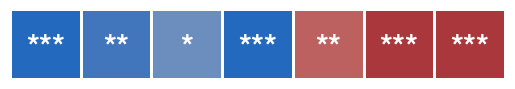

In [467]:
target_gene = 'IL10'
genelist = ['MED24', 'KDM1A', 'NFKB2', 'GATA3', 'SGF29', 'ELOB', 'MEN1']

# Extract data
z_scores = []
lfcs = []
sig_labels = []
gene_mask = adata_de.var['gene_name'] == target_gene

for pert in genelist:
    pert_mask = (adata_de.obs['target_contrast_gene_name_corrected']==pert) & (adata_de.obs['culture_condition']=='Stim8hr')
    lfc = adata_de[pert_mask, gene_mask].layers['log_fc'][0][0]
    lfc_se = adata_de[pert_mask, gene_mask].layers['lfcSE'][0][0]
    adj_p = adata_de[pert_mask, gene_mask].layers['adj_p_value'][0][0]
    z_score = adata_de[pert_mask, gene_mask].layers['zscore'][0][0]
    z_scores.append(lfc / lfc_se if lfc_se != 0 else 0)
    lfcs.append(lfc)
    # Determine significance label
    if adj_p <= 0.001: label = '***'
    elif adj_p <= 0.01: label = '**'
    elif adj_p <= 0.05: label = '*'
    else: label = '' # Use empty string for ns to keep the heatmap clean
    sig_labels.append(label)

# Prepare DataFrame for Heatmap
df_heatmap = pd.DataFrame(lfcs, index=genelist, columns=[target_gene])
annot_matrix = np.array(sig_labels).reshape(-1, 1)

# 2. Plotting
plt.figure(figsize=(0.75*len(genelist),1)) 
ax = sns.heatmap(df_heatmap.T, 
                 annot=annot_matrix.T, 
                 fmt='', 
                 cmap='vlag', 
                 center=0, 
                 vmin=-colormap_thres,
                 vmax=colormap_thres,
                 linewidths=1, 
                 linecolor='white',
                 cbar=False,
                 xticklabels=False,
                 yticklabels=False,
                 annot_kws={'size': 24,
                            'weight': 'bold',
                            'va': 'center_baseline',
                            'color': 'white'})

# Remove Y-axis label as requested
ax.set_ylabel('')

plt.tight_layout()
plt.savefig('./results/validation_summary_plot_perturbseq_heatmap_'+target_gene+'.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [468]:
colormap_thres = 3

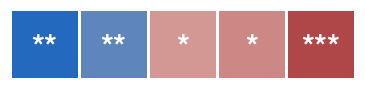

In [469]:
target_gene = 'IL21'
genelist = ['CYB5R4', 'MED24', 'KDM1A', 'NFKB2', 'ATP2A2']

# Extract data
z_scores = []
lfcs = []
sig_labels = []
gene_mask = adata_de.var['gene_name'] == target_gene

for pert in genelist:
    pert_mask = (adata_de.obs['target_contrast_gene_name_corrected']==pert) & (adata_de.obs['culture_condition']=='Stim8hr')
    lfc = adata_de[pert_mask, gene_mask].layers['log_fc'][0][0]
    lfc_se = adata_de[pert_mask, gene_mask].layers['lfcSE'][0][0]
    adj_p = adata_de[pert_mask, gene_mask].layers['adj_p_value'][0][0]
    z_score = adata_de[pert_mask, gene_mask].layers['zscore'][0][0]
    z_scores.append(lfc / lfc_se if lfc_se != 0 else 0)
    lfcs.append(lfc)
    # Determine significance label
    if adj_p <= 0.001: label = '***'
    elif adj_p <= 0.01: label = '**'
    elif adj_p <= 0.05: label = '*'
    else: label = '' # Use empty string for ns to keep the heatmap clean
    sig_labels.append(label)

# Prepare DataFrame for Heatmap
df_heatmap = pd.DataFrame(lfcs, index=genelist, columns=[target_gene])
annot_matrix = np.array(sig_labels).reshape(-1, 1)

# 2. Plotting
plt.figure(figsize=(0.75*len(genelist),1)) 
ax = sns.heatmap(df_heatmap.T, 
                 annot=annot_matrix.T, 
                 fmt='', 
                 cmap='vlag', 
                 center=0, 
                 vmin=-colormap_thres,
                 vmax=colormap_thres,
                 linewidths=1, 
                 linecolor='white',
                 cbar=False,
                 xticklabels=False,
                 yticklabels=False,
                 annot_kws={'size': 24,
                            'weight': 'bold',
                            'va': 'center_baseline',
                            'color': 'white'})

# Remove Y-axis label as requested
ax.set_ylabel('')

plt.tight_layout()
plt.savefig('./results/validation_summary_plot_perturbseq_heatmap_'+target_gene+'.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

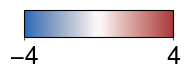

In [430]:
colormap_thres = 4
orientation = 'bottom'
cmap = sns.color_palette("vlag", as_cmap=True)
norm = mpl.colors.Normalize(vmin=-colormap_thres, vmax=colormap_thres)

# Create small horizontal figure
fig, ax = plt.subplots(figsize=(2, 0.9))

# Draw the colorbar
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap=cmap,
    norm=norm,
    orientation='horizontal'
)

# Remove outline and tidy style
cb.outline.set_visible(True)
cb.ax.tick_params(labelsize=18, width=0.5, length=2)
cb.set_ticks([-colormap_thres, colormap_thres])
#cb.set_ticklabels(['0.1', '0.5'])

cb.ax.xaxis.set_ticks_position(orientation)

# Adjust layout
plt.subplots_adjust(left=0.25, right=0.95, top=0.7, bottom=0.45)
plt.tight_layout()
plt.savefig('./results/colorbar_'+str(colormap_thres)+'_'+orientation+'.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

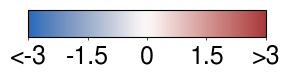

In [474]:
colormap_thres = 3
orientation = 'bottom'
cmap = sns.color_palette("vlag", as_cmap=True)
norm = mpl.colors.Normalize(vmin=-colormap_thres, vmax=colormap_thres)

# Create small horizontal figure
fig, ax = plt.subplots(figsize=(3, 0.9))

# Draw the colorbar
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap=cmap,
    norm=norm,
    orientation='horizontal'
)

# Remove outline and tidy style
cb.outline.set_visible(True)
cb.ax.tick_params(labelsize=18, width=0.5, length=2)
#cb.set_ticks([-colormap_thres, colormap_thres])
#cb.set_ticklabels(['0.1', '0.5'])
tick_locs = [-3, -1.5, 0, 1.5, 3]
cb.set_ticks(tick_locs)

# Set the corresponding labels for the ticks.
tick_labels = ['<-3', '-1.5', '0', '1.5', '>3']
cb.set_ticklabels(tick_labels)

cb.ax.xaxis.set_ticks_position(orientation)

# Adjust layout
plt.subplots_adjust(left=0.25, right=0.95, top=0.7, bottom=0.45)
plt.tight_layout()
plt.savefig('./results/colorbar_'+str(colormap_thres)+'_'+orientation+'.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

## Analyze validation experiment results (BulkRNAseq)

In [380]:
validation_datadir = '../../../../3_expts/Cell_culture_experiments/IL10_IL21_arrayed_validation/bulkRNAseq/'
# Path to folder containing the CSV files
folder_path = '../../../../3_expts/Cell_culture_experiments/IL10_IL21_arrayed_validation/bulkRNAseq/' 
all_files = glob.glob(os.path.join(folder_path, "*_bulkRNAseq.csv"))

dfs = []
for filename in all_files:
    df = pd.read_csv(filename, index_col='gene_id')
    # Keep only columns ending with '_count' along with metadata columns if needed for merge
    # Assuming gene_name and gene_biotype are consistent, we will handle them after merging
    dfs.append(df)

# Merge all dataframes on gene_id, gene_name, and gene_biotype
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = merged_df.merge(df, on=['gene_id', 'gene_name', 'gene_biotype'], how='outer')

# Filter for count columns only
count_cols = [c for c in merged_df.columns if c.endswith('_count')]
final_counts = merged_df[count_cols]

# Prepare var (gene metadata)
gene_meta = merged_df[['gene_name', 'gene_biotype']].copy()

# Prepare X (transpose so rows are observations/samples)
X = final_counts.T

# Prepare obs (sample metadata)
obs_data = []
for col_name in final_counts.columns:
    parts = col_name.split('_')
    donor = parts[0]
    # condition is everything between donor and the suffix '_count'
    condition = "_".join(parts[1:-1]) 
    obs_data.append({'donor': donor, 'sample': condition})

obs_df = pd.DataFrame(obs_data, index=X.index)

# Create AnnData object
adata = ad.AnnData(X=X, obs=obs_df, var=gene_meta)
adata.obs['target_gene'] = adata.obs['sample'].apply(lambda x: "Non-targeting" if "NTC" in x else x)
adata.X = np.rint(adata.X).astype(int)

# Only consider protein-coding genes when running DESeq2
adata = adata[:, adata.var.gene_biotype=='protein_coding'].copy()
# Filter out lowly expressed gene
adata = adata[:,(adata.X.sum(0)>1000)|(adata.var.gene_name.isin(['IL10', 'IL21']))].copy()
adata[:, adata.var.gene_name.isin(['IL10', 'IL21'])].var

# Perform DESeq2
model = pt.tl.PyDESeq2(adata, design='~ donor + target_gene')
model.fit(quiet=True)

# Extract and parse results
all_res_df = pd.DataFrame()
all_targets = adata.obs['target_gene'].unique().tolist()
all_targets.remove('Non-targeting')
for t in all_targets:
    t_contrast = (model.cond(target_gene = t) - model.cond(target_gene = 'Non-targeting')) 
    res_df = model.test_contrasts(t_contrast)
    res_df['contrast'] = t
    all_res_df = pd.concat([all_res_df, res_df])

all_res_df = all_res_df.reset_index().drop('index', axis=1)

all_dfs = {}
for stat in ['baseMean', 'log_fc', 'lfcSE', 'p_value','adj_p_value']:
    stat_df = all_res_df.pivot(values=stat, columns='variable', index='contrast')
    all_dfs[stat] = stat_df

DE_anndata = ad.AnnData(
    layers = all_dfs.copy()
)

DE_anndata.obs_names = all_dfs['log_fc'].index.tolist()
DE_anndata.var_names = all_dfs['log_fc'].columns.tolist()
DE_anndata.obs['sample'] = DE_anndata.obs_names.values
DE_anndata.var['gene_id'] = DE_anndata.var_names
DE_anndata.var['gene_name'] = adata.var['gene_name']

In [164]:
DE_anndata.write_h5ad('../../../../3_expts/Cell_culture_experiments/IL10_IL21_arrayed_validation/bulkRNAseq/DESeq2_results.h5ad')

In [163]:
DE_anndata

AnnData object with n_obs × n_vars = 9 × 10644
    obs: 'sample'
    var: 'gene_id', 'gene_name'
    layers: 'baseMean', 'log_fc', 'lfcSE', 'p_value', 'adj_p_value'

#### Make a summary heatmap plot for IL-10 and IL-21 respectively

In [ ]:
# DE_anndata = ad.write_h5ad('../../../../3_expts/Cell_culture_experiments/IL10_IL21_arrayed_validation/bulkRNAseq/DESeq2_results.h5ad')

In [464]:
colormap_thres = 3

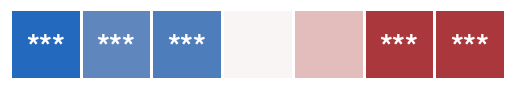

In [465]:
adata = DE_anndata
target_gene = 'IL10'
genelist = ['MED24', 'KDM1A', 'NFKB2', 'GATA3', 'SGF29', 'ELOB', 'MEN1']

# Extract data
z_scores = []
lfcs = []
sig_labels = []
gene_mask = adata.var['gene_name'] == target_gene

for pert in genelist:
    pert_mask = adata.obs['sample'] == pert
    lfc = adata[pert_mask, gene_mask].layers['log_fc'][0][0]
    lfc_se = adata[pert_mask, gene_mask].layers['lfcSE'][0][0]
    adj_p = adata[pert_mask, gene_mask].layers['adj_p_value'][0][0]
    # Calculate Z-score and annotation
    z_scores.append(lfc / lfc_se if lfc_se != 0 else 0)
    lfcs.append(lfc)
    # Determine significance label
    if adj_p <= 0.001: label = '***'
    elif adj_p <= 0.01: label = '**'
    elif adj_p <= 0.05: label = '*'
    else: label = '' # Use empty string for ns to keep the heatmap clean
    sig_labels.append(label)

# Prepare DataFrame for Heatmap
df_heatmap = pd.DataFrame(lfcs, index=genelist, columns=[target_gene])
annot_matrix = np.array(sig_labels).reshape(-1, 1)

# 2. Plotting
plt.figure(figsize=(0.75*len(genelist),1)) 
ax = sns.heatmap(df_heatmap.T, 
                 annot=annot_matrix.T, 
                 fmt='', 
                 cmap='vlag', 
                 center=0, 
                 vmin=-colormap_thres,
                 vmax=colormap_thres,
                 linewidths=1, 
                 linecolor='white',
                 cbar=False,
                 xticklabels=False,
                 yticklabels=False,
                 annot_kws={'size': 24,
                            'weight': 'bold',
                            'va': 'center_baseline',
                            'color': 'white'})

# Remove Y-axis label as requested
ax.set_ylabel('')

plt.tight_layout()
plt.savefig('./results/validation_summary_plot_bulkRNAseq_heatmap_'+target_gene+'.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [458]:
colormap_thres = 3

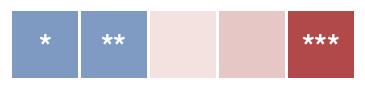

In [459]:
adata = DE_anndata
target_gene = 'IL21'
genelist = ['CYB5R4', 'MED24', 'KDM1A', 'NFKB2', 'ATP2A2']

# Extract data
z_scores = []
lfcs = []
sig_labels = []
gene_mask = adata.var['gene_name'] == target_gene

for pert in genelist:
    pert_mask = adata.obs['sample'] == pert
    lfc = adata[pert_mask, gene_mask].layers['log_fc'][0][0]
    lfc_se = adata[pert_mask, gene_mask].layers['lfcSE'][0][0]
    adj_p = adata[pert_mask, gene_mask].layers['adj_p_value'][0][0]
    # Calculate Z-score and annotation
    z_scores.append(lfc / lfc_se if lfc_se != 0 else 0)
    lfcs.append(lfc)
    # Determine significance label
    if adj_p <= 0.001: label = '***'
    elif adj_p <= 0.01: label = '**'
    elif adj_p <= 0.05: label = '*'
    else: label = '' # Use empty string for ns to keep the heatmap clean
    sig_labels.append(label)

# Prepare DataFrame for Heatmap
df_heatmap = pd.DataFrame(lfcs, index=genelist, columns=[target_gene])
annot_matrix = np.array(sig_labels).reshape(-1, 1)

# 2. Plotting
plt.figure(figsize=(0.75*len(genelist),1)) 
ax = sns.heatmap(df_heatmap.T, 
                 annot=annot_matrix.T, 
                 fmt='', 
                 cmap='vlag', 
                 center=0, 
                 linewidths=1, 
                 vmin=-colormap_thres,
                 vmax=colormap_thres,
                 linecolor='white',
                 cbar=False,
                 xticklabels=False,
                 yticklabels=False,
                 annot_kws={'size': 24,
                            'weight': 'bold',
                            'va': 'center_baseline',
                            'color': 'white'})

# Remove Y-axis label as requested
ax.set_ylabel('')


plt.tight_layout()
plt.savefig('./results/validation_summary_plot_bulkRNAseq_heatmap_'+target_gene+'.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

## Plot validation experiment results (Flow)

In [481]:
validation_datadir = '../../../../3_expts/Cell_culture_experiments/IL10_IL21_arrayed_validation/Flow/'

In [482]:
df = pd.read_csv(validation_datadir+'IL10_IL21_arrayed_validation.csv')
# Calculate NTC Mean per Donor
ntc = df[df['Perturbation'].str.contains('NTC')][['Donor', 'IL10_perc', 'IL21_perc']]

ntc = ntc.groupby('Donor')[['IL10_perc', 'IL21_perc']].mean().reset_index()

ntc.columns = ['Donor', 'IL10_NTC_Mean', 'IL21_NTC_Mean']

# Merge means back and calculate Fold Change & Log2 Fold Change
df = df.merge(ntc, on='Donor', how='left')

df['IL10_FC'] = df['IL10_perc'] / df['IL10_NTC_Mean']
df['IL21_FC'] = df['IL21_perc'] / df['IL21_NTC_Mean']

df['IL10_Log2FC'] = np.log2(df['IL10_FC'])
df['IL21_Log2FC'] = np.log2(df['IL21_FC'])

In [483]:
colormap_thres = 3

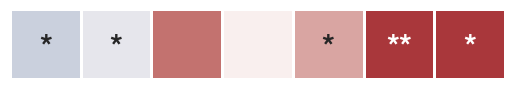

In [484]:
target_gene = 'IL10'
genes_down = ['MED24', 'KDM1A', 'NFKB2', 'GATA3']
genes_up = ['SGF29', 'ELOB', 'MEN1']
genelist = genes_down + genes_up
target_col = target_gene+'_Log2FC'

z_scores = []
lfcs = []
raw_pvals = []

# Calculate Z-scores and raw p-values
for pert in genelist:
    vals = df[df['Perturbation'] == pert][target_col].dropna()
    
    if len(vals) > 0:
        mean = vals.mean()
        sem = stats.sem(vals) if len(vals) > 1 else 0
        z = mean / sem if sem > 0 else 0
        
        # Determine test direction
        if pert in genes_up:
            # One-sided: greater
            _, p = stats.ttest_1samp(vals, 0, alternative='greater') if sem > 0 else (0, 1.0)
        else:
            # One-sided: less
            _, p = stats.ttest_1samp(vals, 0, alternative='less') if sem > 0 else (0, 1.0)
    else:
        z = 0
        p = 1.0
        
    z_scores.append(z)
    lfcs.append(mean)
    raw_pvals.append(p)

# FDR Correction (Benjamini-Hochberg)
_, fdr_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')

# Map FDR to stars
sig_labels = []
for p in fdr_pvals:
    if p <= 0.001: label = '***'
    elif p <= 0.01: label = '**'
    elif p <= 0.05: label = '*'
    else: label = ''
    sig_labels.append(label)

# Prepare DataFrames
df_heatmap = pd.DataFrame(lfcs, index=genelist, columns=['IL10'])
annot_matrix = np.array(sig_labels).reshape(-1, 1)

# Plotting
plt.figure(figsize=(0.75*len(genelist),1))
ax = sns.heatmap(df_heatmap.T, 
                 annot=annot_matrix.T, 
                 fmt='', 
                 cmap='vlag', 
                 vmin=-colormap_thres,
                 vmax=colormap_thres,
                 center=0, 
                 linewidths=1, 
                 linecolor='white',
                 cbar=False,
                 xticklabels=False, 
                 yticklabels=False,
                 annot_kws={'size': 24,
                            'weight': 'bold',
                            'va': 'center_baseline',})
                            #'color': 'white'})

ax.set_ylabel('')
plt.tight_layout()
plt.savefig('./results/validation_summary_plot_staining_heatmap_'+target_gene+'.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [485]:
colormap_thres = 3

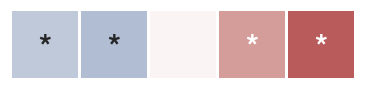

In [486]:
target_gene = 'IL21'
genes_down = ['CYB5R4', 'MED24']
genes_up = ['KDM1A', 'NFKB2', 'ATP2A2']
genelist = genes_down + genes_up
target_col = target_gene+'_Log2FC'

z_scores = []
lfcs = []
raw_pvals = []

# Calculate Z-scores and raw p-values
for pert in genelist:
    vals = df[df['Perturbation'] == pert][target_col].dropna()
    
    if len(vals) > 0:
        mean = vals.mean()
        sem = stats.sem(vals) if len(vals) > 1 else 0
        z = mean / sem if sem > 0 else 0
        
        # Determine test direction
        if pert in genes_up:
            # One-sided: greater
            _, p = stats.ttest_1samp(vals, 0, alternative='greater') if sem > 0 else (0, 1.0)
        else:
            # One-sided: less
            _, p = stats.ttest_1samp(vals, 0, alternative='less') if sem > 0 else (0, 1.0)
    else:
        z = 0
        p = 1.0
        
    z_scores.append(z)
    lfcs.append(mean)
    raw_pvals.append(p)

# FDR Correction (Benjamini-Hochberg)
_, fdr_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')

# Map FDR to stars
sig_labels = []
for p in fdr_pvals:
    if p <= 0.001: label = '***'
    elif p <= 0.01: label = '**'
    elif p <= 0.05: label = '*'
    else: label = ''
    sig_labels.append(label)

# Prepare DataFrames
df_heatmap = pd.DataFrame(lfcs, index=genelist, columns=['IL10'])
annot_matrix = np.array(sig_labels).reshape(-1, 1)

# Plotting
plt.figure(figsize=(0.75*len(genelist),1))
ax = sns.heatmap(df_heatmap.T, 
                 annot=annot_matrix.T, 
                 fmt='', 
                 cmap='vlag', 
                 vmin=-colormap_thres,
                 vmax=colormap_thres,
                 center=0, 
                 linewidths=1, 
                 linecolor='white',
                 cbar=False,
                 xticklabels=False, 
                 yticklabels=False,
                 annot_kws={'size': 24,
                            'weight': 'bold',
                            'va': 'center_baseline',})
                            #'color': 'white'})

ax.set_ylabel('')
plt.tight_layout()
plt.savefig('./results/validation_summary_plot_staining_heatmap_'+target_gene+'.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

### Swarmplot for supplementary figure

In [492]:
def get_pvalue_annotation(lfc_data, reg_type):
    # Perform one-sample t-test comparing the LFC data to a mean of 0 (Null Hypothesis: mean LFC = 0)
    # The 'nan_policy="omit"' handles missing data gracefully if you have incomplete donor data
    if reg_type=='pos':
        _, p_value = ttest_1samp(lfc_data.dropna(), 0, nan_policy='omit', alternative='less')
    elif reg_type=='neg':
        _, p_value = ttest_1samp(lfc_data.dropna(), 0, nan_policy='omit', alternative='greater')

    return p_value

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_54918/677808947.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks)


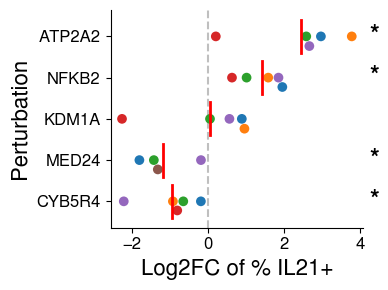

In [593]:
target_gene = 'IL21'
genelist = ['ATP2A2', 'NFKB2', 'KDM1A', 'MED24', 'CYB5R4']
subset = df[df['Perturbation'].isin(genelist)].copy()
subset['Perturbation'] = pd.Categorical(subset['Perturbation'], categories=genelist, ordered=True)
subset = subset.sort_values('Perturbation')

plt.figure(figsize=(4, 3))
ax = sns.swarmplot(data=subset, x=target_gene+'_Log2FC', y='Perturbation', size=7, hue='Donor')
ax.legend_.remove()

# Draw Red Mean Lines
means = subset.groupby('Perturbation', observed=True)[target_gene+'_Log2FC'].mean()
for i, gene in enumerate(genelist):
    if gene in means:
        plt.plot([means[gene], means[gene]], [i - 0.4, i + 0.4], color='red', linewidth=2, zorder=5)

plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Log2 Fold Change')

yticks = ax.get_yticklabels()
for i, tick in enumerate(yticks):
    tick.set_fontsize(12)

xticks = ax.get_xticklabels()
for i, tick in enumerate(xticks):
    tick.set_fontsize(12)

ax.set_yticklabels(yticks)
ax.set_ylabel('Perturbation', fontsize=16)
ax.set_xlabel('Log2FC of % IL21+', fontsize=16)

gene_reg_type = {
    'ATP2A2': 'neg',
    'NFKB2': 'neg',
    'KDM1A': 'neg',
    'MED24': 'pos',
    'CYB5R4': 'pos'
}

raw_pvals = subset.groupby('Perturbation', observed=True)[target_gene+'_Log2FC'].apply(
    # The lambda function receives the Log2FC data (lfc_data) for the current group
    # The group name (gene) is available as lfc_data.name
    lambda lfc_data: get_pvalue_annotation(
        lfc_data, 
        reg_type=gene_reg_type.get(lfc_data.name, 'na') # Use .get() to look up the reg_type
    )
)

_, fdr_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')

annotations = []
for p in fdr_pvals:
    if p <= 0.001: label = '***'
    elif p <= 0.01: label = '**'
    elif p <= 0.05: label = '*'
    else: label = ''
    annotations.append(label)

y_coords = np.arange(len(genelist))
for i, gene in enumerate(genelist):
    annotation_text = annotations[i]
    max_abs_lfc = subset[subset['Perturbation'] == gene][target_gene+'_Log2FC'].abs().max()
    x_pos_text = max_abs_lfc + 0.05
    x_limit = ax.get_xlim()[1]
    x_pos_text = x_limit + 0.15
    
    # Add the text annotation
    ax.text(x_pos_text, 
            y_coords[i], 
            annotation_text, 
            ha='left', 
            va='center', 
            fontsize=18, 
            weight='bold',
            color='black',
            clip_on=False) # Allow text outside the main plot area

plt.tight_layout()
sns.despine()
plt.savefig('./results/validation_swarmplot_'+target_gene+'.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_54918/4095614620.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks)


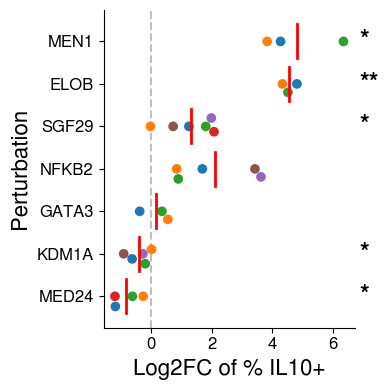

In [594]:
target_gene = 'IL10'
genelist = ['MEN1', 'ELOB', 'SGF29', 'NFKB2', 'GATA3', 'KDM1A', 'MED24']
subset = df[df['Perturbation'].isin(genelist)].copy()
subset['Perturbation'] = pd.Categorical(subset['Perturbation'], categories=genelist, ordered=True)
subset = subset.sort_values('Perturbation')

plt.figure(figsize=(4, 4))
ax = sns.swarmplot(data=subset, x=target_gene+'_Log2FC', y='Perturbation', size=7, hue='Donor')
ax.legend_.remove()

# Draw Red Mean Lines
means = subset.groupby('Perturbation', observed=True)[target_gene+'_Log2FC'].mean()
for i, gene in enumerate(genelist):
    if gene in means:
        plt.plot([means[gene], means[gene]], [i - 0.4, i + 0.4], color='red', linewidth=2, zorder=5)

plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Log2 Fold Change')

yticks = ax.get_yticklabels()
for i, tick in enumerate(yticks):
    tick.set_fontsize(12)

xticks = ax.get_xticklabels()
for i, tick in enumerate(xticks):
    tick.set_fontsize(12)

ax.set_yticklabels(yticks)
ax.set_ylabel('Perturbation', fontsize=16)
ax.set_xlabel('Log2FC of % IL10+', fontsize=16)

gene_reg_type = {
    'MEN1': 'neg',
    'ELOB': 'neg',
    'SGF29': 'neg',
    'NFKB2': 'pos',
    'GATA3': 'pos',
    'KDM1A': 'pos',
    'MED24': 'pos',
}

raw_pvals = subset.groupby('Perturbation', observed=True)[target_gene+'_Log2FC'].apply(
    # The lambda function receives the Log2FC data (lfc_data) for the current group
    # The group name (gene) is available as lfc_data.name
    lambda lfc_data: get_pvalue_annotation(
        lfc_data, 
        reg_type=gene_reg_type.get(lfc_data.name, 'na') # Use .get() to look up the reg_type
    )
)

_, fdr_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')

annotations = []
for p in fdr_pvals:
    if p <= 0.001: label = '***'
    elif p <= 0.01: label = '**'
    elif p <= 0.05: label = '*'
    else: label = ''
    annotations.append(label)

y_coords = np.arange(len(genelist))
for i, gene in enumerate(genelist):
    annotation_text = annotations[i]
    max_abs_lfc = subset[subset['Perturbation'] == gene][target_gene+'_Log2FC'].abs().max()
    x_pos_text = max_abs_lfc + 0.05
    x_limit = ax.get_xlim()[1]
    x_pos_text = x_limit + 0.15
    
    # Add the text annotation
    ax.text(x_pos_text, 
            y_coords[i], 
            annotation_text, 
            ha='left', 
            va='center', 
            fontsize=18, 
            weight='bold',
            color='black',
            clip_on=False) # Allow text outside the main plot area

plt.tight_layout()
sns.despine()
plt.savefig('./results/validation_swarmplot_'+target_gene+'.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

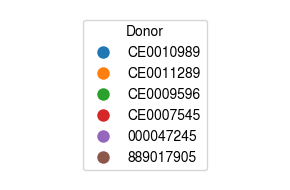

In [595]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define the donor colors and labels used in the original swarmplot
# Note: Seaborn/Matplotlib cycles through a default color palette. 
# We'll use the default 'tab10' palette colors that typically correspond to the first four categories.
# If your original plot used a custom palette, you must replace these hex codes.
donor_colors = {
    'CE0010989': '#1f77b4', # Default blue
    'CE0011289': '#ff7f0e', # Default orange
    'CE0009596': '#2ca02c', # Default green
    'CE0007545': '#d62728',  # Default red
    '000047245': '#9467bd', # Default purple
    '889017905': '#8c564b',  # Default brown
}

# Get the labels and colors for the legend
labels = list(donor_colors.keys())
colors = list(donor_colors.values())

# Create a new figure just for the legend
plt.figure(figsize=(3, 2))
ax_legend = plt.gca()

# Manually create Line2D artists for the legend.
# Since the original plot used a swarmplot (scatter-like), we use markers.
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=color, markersize=10)
    for label, color in zip(labels, colors)
]

# Add the legend to the new axes
legend = ax_legend.legend(handles=legend_elements, 
                          title='Donor', 
                          loc='center', 
                          frameon=True)

# Remove the axes lines, ticks, and labels to make it a "standalone" legend
ax_legend.axis('off')

# Increase the font size of the legend title and labels for better visibility
plt.setp(legend.get_title(), fontsize='10') # Adjust title font size
plt.setp(legend.get_texts(), fontsize='10') # Adjust label font size

plt.tight_layout()
plt.savefig('./results/validation_swarmplot_standalone_legend.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

### Scatter plot showing the correlation of bulk RNAseq and perturb-seq for supplementary figure

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_54918/3847230541.py:134: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


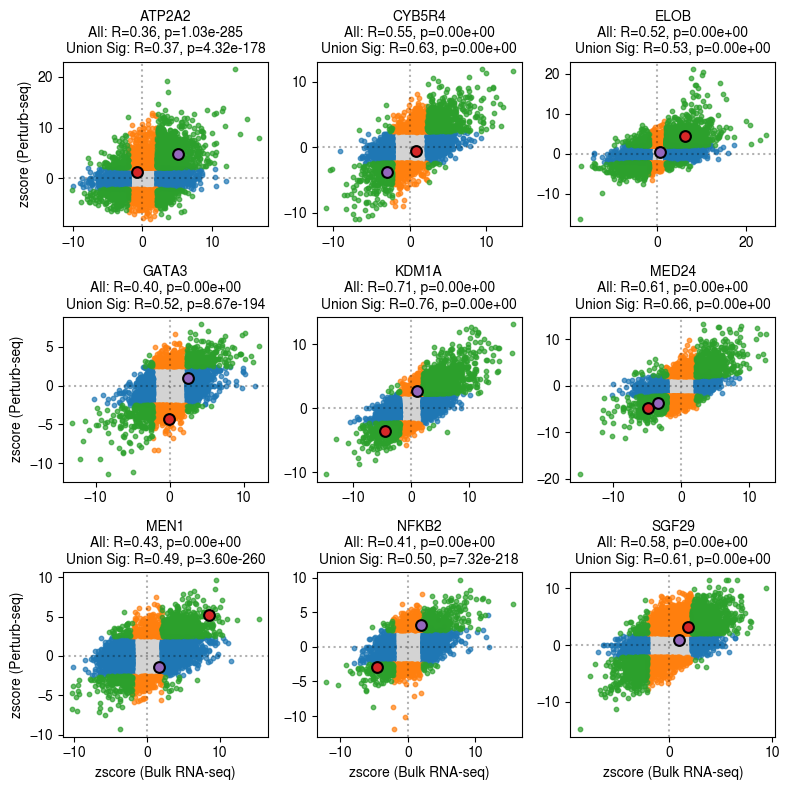

In [596]:
DE_anndata.layers['zscore'] = DE_anndata.layers['log_fc']/DE_anndata.layers['lfcSE']
DE_anndata_zscore = DE_anndata.layers['zscore'].copy()
DE_anndata_padj = DE_anndata.layers['adj_p_value'].copy()
adata_subset_padj = adata_subset.layers['adj_p_value'].copy()

for pert in DE_anndata.obs['sample']:
    DE_anndata_zscore[DE_anndata.obs['sample']==pert, DE_anndata.var.gene_name==pert] = 0
    DE_anndata_padj[DE_anndata.obs['sample']==pert, DE_anndata.var.gene_name==pert] = 1
    adata_subset_padj[adata_subset.obs['target_contrast_gene_name']==pert, adata_subset.var.gene_name==pert] = 1

DE_anndata.layers['masked_zscore'] = DE_anndata_zscore.copy()
DE_anndata.layers['masked_padj'] = DE_anndata_padj.copy()
adata_subset.layers['masked_padj'] = adata_subset_padj.copy()

de_genes = DE_anndata.var['gene_id'].astype(str)
sub_genes = adata_subset.var['gene_ids'].astype(str)

# Extract zscore data
de_df = DE_anndata.to_df(layer='masked_zscore')
de_df.columns = de_genes

sub_df = adata_subset.to_df(layer='masked_zscore')
sub_df.columns = sub_genes

# Extract P-values (assuming layers exist as shown in your images)
# We cast to DataFrame to easily align with gene names
de_pval = pd.DataFrame(DE_anndata.layers['masked_padj'], 
                       index=DE_anndata.obs_names, 
                       columns=de_genes)
sub_pval = pd.DataFrame(adata_subset.layers['masked_padj'], 
                        index=adata_subset.obs_names, 
                        columns=sub_genes)

# Identify common downstream genes
common_genes = np.intersect1d(de_genes, sub_genes)
# Remove 'nan' string if it was created from NaN values
common_genes = common_genes[common_genes != 'nan']

# Get list of perturbations (samples)
perturbations = DE_anndata.obs['sample'].values

# --- Plotting ---

fig, axes = plt.subplots(3, 3, figsize=(8, 8), constrained_layout=True)
axes = axes.flatten()

# Color definitions
c_ns = 'lightgray'   # Not significant
c_de = '#1f77b4'     # Bulk only (Blue)
c_sub = '#ff7f0e'    # Perturb only (Orange)
c_both = '#2ca02c'   # Both (Green)
c_il10 = '#d62728'   # IL10 (Red)
c_il21 = '#9467bd'   # IL21 (Purple)

for i, pert in enumerate(perturbations):
    ax = axes[i]
    
    # Identify the corresponding rows in each dataset
    # DE_anndata uses 'sample' column
    de_idx = DE_anndata.obs['sample'] == pert
    # adata_subset uses 'target_contrast_gene_name' column
    sub_idx = adata_subset.obs['target_contrast_gene_name'] == pert
    
    if not np.any(sub_idx):
        ax.text(0.5, 0.5, f"{pert} not found in subset", ha='center')
        continue

    # Extract aligned data vectors for common genes
    # flatten() ensures we get 1D arrays
    x = de_df.loc[de_idx, common_genes].values.flatten()
    y = sub_df.loc[sub_idx, common_genes].values.flatten()
    px = de_pval.loc[de_idx, common_genes].values.flatten()
    py = sub_pval.loc[sub_idx, common_genes].values.flatten()
    
    # Handle potential NaNs
    x = np.nan_to_num(x, nan=0)
    y = np.nan_to_num(y, nan=0)
    px = np.nan_to_num(px, nan=1.0)
    py = np.nan_to_num(py, nan=1.0)
    
    # Define masks for coloring (cutoff 0.1)
    sig_x = px < 0.1
    sig_y = py < 0.1
    
    mask_both = sig_x & sig_y
    mask_x_only = sig_x & ~sig_y
    mask_y_only = ~sig_x & sig_y
    mask_ns = ~(sig_x | sig_y)
    
    # Scatter plots by group
    # Not significant (small, gray)
    ax.scatter(x[mask_ns], y[mask_ns], c=c_ns, s=3, alpha=0.5, rasterized=True)
    
    # Significant categories (intermediate size)
    ax.scatter(x[mask_x_only], y[mask_x_only], c=c_de, s=10, alpha=0.7)
    ax.scatter(x[mask_y_only], y[mask_y_only], c=c_sub, s=10, alpha=0.7)
    ax.scatter(x[mask_both], y[mask_both], c=c_both, s=10, alpha=0.7)
    
    # Highlight IL10 and IL21
    for gene, color in zip(['ENSG00000136634', 'ENSG00000138684'], [c_il10, c_il21]):
        if gene in common_genes:
            # Find index of this gene in the common_genes array
            g_indices = np.where(common_genes == gene)[0]
            if len(g_indices) > 0:
                ax.scatter(x[g_indices], y[g_indices], c=color, s=60, 
                           edgecolors='black', linewidth=1.5, zorder=10)

    # Calculate Correlations
    # 1. All common genes
    if len(x) > 1:
        r_all, p_all = pearsonr(x, y)
    else:
        r_all, p_all = np.nan, np.nan
        
    # 2. Union of significant genes
    mask_union = sig_x | sig_y
    if np.sum(mask_union) > 1:
        r_sig, p_sig = pearsonr(x[mask_union], y[mask_union])
        title_stats = f"All: R={r_all:.2f}, p={p_all:.2e}\nUnion Sig: R={r_sig:.2f}, p={p_sig:.2e}"
    else:
        title_stats = f"All: R={r_all:.2f}, p={p_all:.2e}\nUnion Sig: N/A"
    
    ax.set_title(f"{pert}\n{title_stats}", fontsize=10)
    
    # Axis styling
    ax.axhline(0, color='k', linestyle=':', alpha=0.3)
    ax.axvline(0, color='k', linestyle=':', alpha=0.3)
    
    if i >= 6: # Label x-axis for bottom row
        ax.set_xlabel("zscore (Bulk RNA-seq)")
    if i % 3 == 0: # Label y-axis for left column
        ax.set_ylabel("zscore (Perturb-seq)")

plt.tight_layout()
plt.savefig('./results/validation_bulkRNAseq_scatterplot.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_54918/1672005102.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


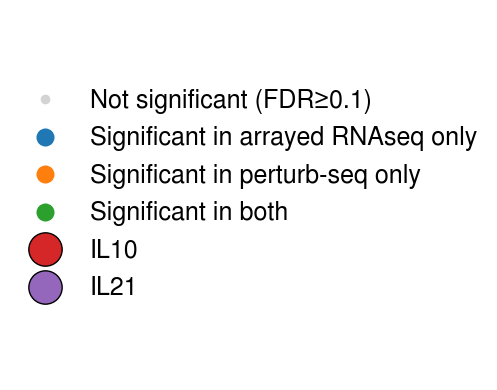

In [599]:
fig_leg, ax_leg = plt.subplots(figsize=(3, 4), constrained_layout=True)
legend_elements = [
    mlines.Line2D([], [], color='white', marker='o', markerfacecolor=c_ns, label='Not significant (FDR≥0.1)', markersize=8),
    mlines.Line2D([], [], color='white', marker='o', markerfacecolor=c_de, label='Significant in arrayed RNAseq only', markersize=14),
    mlines.Line2D([], [], color='white', marker='o', markerfacecolor=c_sub, label='Significant in perturb-seq only', markersize=14),
    mlines.Line2D([], [], color='white', marker='o', markerfacecolor=c_both, label='Significant in both', markersize=14),
    mlines.Line2D([], [], color='white', marker='o', markerfacecolor=c_il10, label='IL10', markersize=24, markeredgecolor='black'),
    mlines.Line2D([], [], color='white', marker='o', markerfacecolor=c_il21, label='IL21', markersize=24, markeredgecolor='black')
]
ax_leg.legend(handles=legend_elements, loc='center', ncol=1, frameon=False, fontsize=18)
ax_leg.axis('off')
plt.tight_layout()
plt.savefig('./results/validation_bulkRNAseq_standalone_legend.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()